In [19]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

import pandas as pd
pyro.set_rng_seed(0)

In [20]:
# Helper function for plotting. Source: https://pyro.ai/examples/gp.html
def plot(
    X,
    y,
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
    xlim=None
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(X[0], X[-1], n_test, dtype=torch.double)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(X[0], X[-1], n_test, dtype=torc.double)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    else:
        ax.set_xlim(X[0], X[-1])

In [21]:
df_price = pd.read_csv('../data/BTC-USD.csv', parse_dates=True)
df_price['Adj Close'] = np.log(df_price['Adj Close'])
data = torch.tensor(df_price['Adj Close'].values, dtype=torch.double)

In [22]:
X = torch.tensor(range(len(data[:-365])), dtype=torch.double)
y = data[:-365]

X_test = torch.tensor(range(len(data[-365:])), dtype=torch.double)
y_test = data[-365:]




In [23]:

def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text



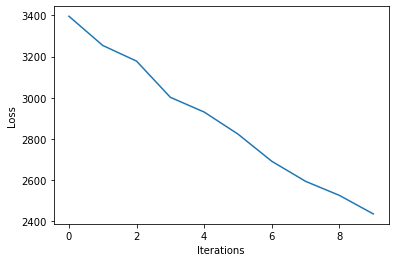

In [24]:
pyro.clear_param_store()
linear = gp.kernels.Linear(
    input_dim=1,
)
periodic = gp.kernels.Periodic(
    input_dim=1, period=torch.tensor(0.5), lengthscale=torch.tensor(4.0)
)
rbf = gp.kernels.RBF(
    input_dim=1, lengthscale=torch.tensor(4.0), variance=torch.tensor(1)
)
k1 = gp.kernels.Product(kern0=rbf, kern1=periodic)

k = gp.kernels.Sum(linear, k1)
model = gp.models.GPRegression(
    X=X,
    y=y,
    kernel=k,
)

loss = gp.util.train(model, num_steps=10, optimizer=torch.optim.Adam(model.parameters(), lr=0.05))
plot_loss(loss)

In [25]:
X_full = torch.tensor(range(len(data)), dtype=torch.double)
y_full = data

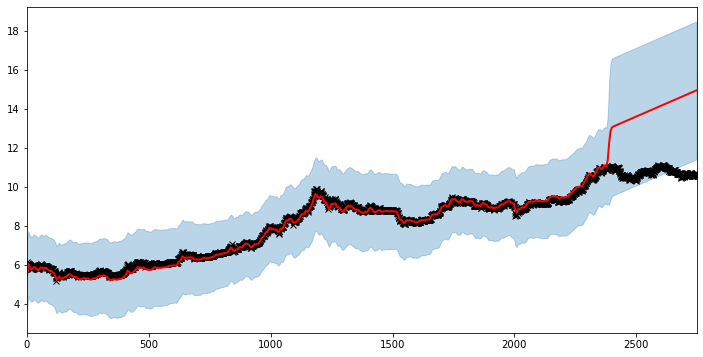

In [27]:
plot(X_full, y_full, model=model, plot_observed_data=True, plot_predictions=True, xlim=(0, len(data)))
